# Categorical perception as optimal statistical inference

It is known that categories can affect the perception of stimuli.  A specific type of categorical perception is the so-called perceptual magnet effect in vowel perception, in which discriminability between vowels is reduced near vowel prototypes.  Feldman et al. 2009 argued that this effect is a natural consequence of "optimally solving the statistical problem of perception in noise" (p. 752).  They presented a Bayesian model that embodies that idea, and showed that it accounts for data from a vowel discrimination experiment by Iverson and Kuhl (1995).  

In this homework, you will replicate their findings.

Many thanks to [Naomi Feldman](http://users.umiacs.umd.edu/~nhf/) for sharing her Matlab code and data.  And many thanks to [Geoff Bacon](https://geoffbacon.github.io/) for using that as a basis for writing the first draft of this notebook.

In [1]:
import math
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

### Data

First hard-code the Iverson and Kuhl data, and then plot it so we have a clean picture of what model output should look like.  

As Feldman et al. report (p. 759):

> Iverson and Kuhl’s (1995) multidimensional scaling experiment was conducted with thirteen vowel stimuli along a single continuum in $F_1–F_2$ space ranging from /i/ to /e/ [...] The stimuli were designed to be equally spaced when measured along the mel scale, which equates distances on the basis of difference limens (S. S. Stevens et al., 1937). Subjects performed an AX discrimination task in which they pressed and held a button to begin a trial, releasing the button as quickly as possible if they believed the two stimuli to be different or holding the button for the remainder of the trial (2000 ms) if they heard no difference between the two stimuli. Subjects heard 156 “different” trials, consisting of all possible ordered pairs of nonidentical stimuli, and 52 “same” trials, four of each of the 13 stimuli.


Iverson and Kuhl analyzed reaction time rather than accuracy, and used it to create a dissimilarity matrix, which they provided as input to a multi-dimensional scaling (MDS) analysis.  They asked for the data to be arranged by MDS along a single perceptual dimension, since the input was along a single continuum.  The stimuli along that continuum are numbered from 1 to 13, with a prototypical /i/ located halfway between stimuli 2 and 3, and a prototypical /e/ located just to the left of stimulus 13 &mdash; thus, the prototypes for the two categories are near the two extremes of the continuum, and the category boundary is near the middle.  Iverson and Kuhl's data show that the relative perceptual distance between neighboring stimuli tends to be low near the prototypes at the two extremes of the continuum, and higher near the category boundary toward the middle of the continuum.  This is the perceptual magnet effect: reduced discriminability near vowel prototypes.  Of course another way of viewing the same phenomonen is: enhanced discriminability away from prototypes and near boundaries.

In [2]:
# first copy the list containing the data from naomi's matlab code, 
# then convert to a dict indexed by stimulus pair.
# we index by stimulus pair because the values here are relative perceptual distance between
# neighboring stimuli.
data_list = [.5, .69, .56, .88, 1.18, 1.46, 1.75, 1.53, 1.25, 1.07, .88, .83]
data = {(i,i+1):data_list[i-1] for i in range(1,12+1)}  # YOUR CODE GOES HERE.
data

{(1, 2): 0.5,
 (2, 3): 0.69,
 (3, 4): 0.56,
 (4, 5): 0.88,
 (5, 6): 1.18,
 (6, 7): 1.46,
 (7, 8): 1.75,
 (8, 9): 1.53,
 (9, 10): 1.25,
 (10, 11): 1.07,
 (11, 12): 0.88,
 (12, 13): 0.83}

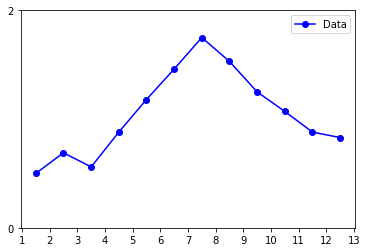

In [3]:
# now plot the iverson & kuhl data, following F et al.
xt = [i+1 for i in range(len(data)+1)]   # x tick mark posns, at stimulus numbers
x = [(i+j)/2 for (i,j) in data.keys()]  # actual x values to plot, *between* stimulus numbers
y = list(data.values())
plt.plot(x,y, 'bo-')  # blue, circle marker, solid line
plt.xticks(xt,xt)
plt.yticks([0,2])
plt.ylim(0,2)
plt.legend(['Data'])
plt.show()

### Model

The main variables of the model are:
- $c$: category
- $T$: target sound, as intended by speaker
- $S$: stimulus, as actually received by listener

The global structure of the model is:

> $c \rightarrow T \rightarrow S$

That is, the speaker has a category $c$ in mind, which defines a distribution over sounds.  The speaker then produces a specific target sound $T$ that is drawn from that distribution.  The listener does not perceive $T$ directly &mdash; instead the listener perceives a stimulus $S$ that is the result of perceiving $T$ in the presence of noise.  The listener then reconstructs what s/he thinks $T$ must have been, given knowledge of $S$ and $c$.

We assume a two-category model, because our data have two categories (/i/ and /e/).  In this case, the listener reconstruction of $T$ is given by equation 11 of Feldman et al.:

\begin{align}
E[T|S] = \frac{\sigma^2_c}{\sigma^2_c + \sigma^2_S}S + \frac{\sigma^2_S}{\sigma^2_c + \sigma^2_S}\sum_c p(c|S) \mu_c.
\end{align}

where:
- $c$ ranges over the two categories;
- Each category is represented as a Gaussian (normal) distribution with mean (prototype) $\mu_c$ and variance $\sigma^2_c$;
- We assume the categories have different means $\mu_c$ but the same variance $\sigma^2_c$;
- The received stimulus $S$ is also represented as a Gaussian, with variance $\sigma^2_S$;
- $p(c|S)$ is defined below, and represents the probability that stimulus $S$ will be categorized as $c$ rather than some other category.

Feldman et al. (p. 759) point out that the above formula for $E[T|S]$ is:
> a weighted average of the stimulus $S$ [first term] and the means $\mu_c$ of all the categories that might have produced $S$ [second term].

There are two qualitative points to highlight in this regard.

1. This average is weighted by **certainty**.  The fractions that specify the weights for the two terms have the same denominator and differ only in the numerator: thus, the stimulus $S$ is weighted proportionally to the category variance $\sigma^2_c$, and the category means $\mu_c$ are weighted proportionally to the variance of the stimulus, $\sigma^2_S$.  We can assume that $\sigma^2_c$ is fixed, since the categories are presumed to be static.  This means that the relative weighting of the two terms can be affected only by $\sigma^2_S$, the variance of the stimulus.  The greater this variance, i.e. the more uncertain the listener is of the actual value of $S$, the more weight is given to the categories and the less to the stimulus.  Conversely, when the listener is quite certain of the stimulus $S$, $\sigma^2_S$ will be small, and little weight will be given to the category and more to the stimulus itself.  In effect, this formula assigns more weight to the stimulus when the listener is relatively certain of the stimulus &mdash; it is in that sense that the average is weighted by certainty.
2. The category term in this equation (the second term) is itself a weighted average, over categories.  As Feldman et al. point out (p. 759):
>When perceivers are certain of a stimulus’s category, [i.e. when $p(c|S)$ is 1 for a particular category $c$, and 0 for the other category] perception of a stimulus $S$ is biased toward the mean of its category. However, when a stimulus is on a border between two categories, the optimal guess at the target is influenced by both category means, and each category weakens the other's effect [because they pull in opposite directions, essentially canceling each other out]. Shrinkage of perceptual space is thus strongest in areas of unambiguous categorization &mdash; the centers of categories &mdash; and weakest at category boundaries.

The final element that needs exposition is $p(c|S)$, the probability that stimulus $S$ will be categorized as $c$ rather than some other category.  Following the assumptions of Feldman et al. (namely that there are two categories with equal variance), this takes the form of a logistic function (equation 12, p. 762):
\begin{align}
p(c_1|S) = \frac{1}{1+\exp(-gS+b)}
\end{align}
where 
\begin{align}
g = \frac{\mu_1 - \mu_2}{\sigma^2_c + \sigma^2_S}
\end{align}
and
\begin{align}
b = \frac{\mu_1^2 - \mu_2^2}{2 (\sigma^2_c + \sigma^2_S)}.
\end{align}
$p(c_2|S)$ is then simply $1 - p(c_1|S)$.

In [4]:
# defining global variables holding the values of various parameters.
# obtained from feldman et al., pp. 759-761.

# define stimulus numbers.
stims = list(range(1,13+1))  # numbers 1-13 inclusive

# define categories and their means.
cats = ['/i/', '/e/']  # categories
mu = {'/i/': 2.5, '/e/': 12.8}  # category means

# variances.
# sigma_c_2 is the category variance, which is shared, i.e. same variance for each of the two categories.
# sigma_s_2 is the stimulus variance, capturing listener's uncertainty about the stimulus.
# F et al. rather confusingly report these values in mel or mel^2 without specifying how many mel
# each unit on our stimulus spectrum corresponds to - turns out the answer is 30, see lotto et al., 
# p. 3650.  so the values i am using here are adjusted accordingly from those reported in F et al.
# i am hard-coding these in for now, but later fit to data, poss under the constraint that:
# sigma_c_2 + sigma_s_2 = 11.575555555.
sigma_c_2 = 6.587777779
sigma_s_2 = 4.987777776
summed_sigma_2 = sigma_c_2 + sigma_s_2

In [5]:
# pcs stands for p(c|S), the probability that stimulus S is categorized as c.
# this function implements equation 12 on page 762 of feldman et al., for both categories c.
def pcs(s,mu,sigma_c_2,sigma_s_2):
    """
    receives as input:
    s, a stimulus number
    mu, the means of the categories
    sigma_c_2, the category variance
    sigma_s_2, the stimulus variance
    returns: a dict holding, for each category c, p(c|s), 
    i.e. the probability that s would be categorized as c.
    """

    # YOUR CODE GOES HERE.
    mu1 = mu['/i/']
    mu2 = mu['/e/']
    g = (mu1 - mu2) / (sigma_c_2 + sigma_s_2)
    b = (mu1**2 - mu2**2) / (2*(sigma_c_2 + sigma_s_2))

    p = {}  # return results in this dict
    p['/i/'] = 1 / (1 + np.exp(-g * s + b))  # REPLACE - YOUR CODE GOES HERE.
    p['/e/'] = 1 - p['/i/']  # REPLACE - YOUR CODE GOES HERE.
    return(p)

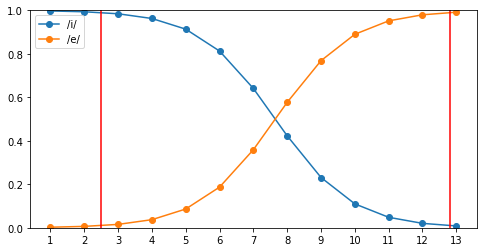

In [6]:
# sanity-check: compute and plot p(c|S) for both cats, for all stimuli.
# should look like fig 4 of F et al.
p_i = []
p_e = []
for s in stims:
    p = pcs(s,mu,sigma_c_2,sigma_s_2)
    p_i.append(p['/i/'])
    p_e.append(p['/e/'])
plt.figure(figsize=(8,4))
plt.plot(stims,p_i, 'o-', label='/i/')
plt.plot(stims,p_e, 'o-', label='/e/')
plt.legend()
plt.xticks(stims)
plt.ylim(0,1)
plt.axvline(mu['/i/'], color='r')
plt.axvline(mu['/e/'], color='r')
plt.show()

In [7]:
# r = reconstruction.
# this function computes the listener's reconstruction of a target speech sound given the stimulus perceived,
# i.e. E[T\S] as given by equation 11, p. 759.
def r(x,cats,mu,sigma_c_2,sigma_s_2):
    """
    receives as input:
    x, a stimulus number
    cats, the categories
    mu, the category means
    sigma_c_2, the category variance
    sigma_s_2, the stimulus variance
    returns: the reconstruction of that stimulus, including category-induced bias.
    """
    
    # YOUR CODE GOES HERE.
    term_1 = (sigma_c_2 / (sigma_c_2 + sigma_s_2)) * x
    ps = pcs(x,mu,sigma_c_2,sigma_s_2)
    total = sum([ps[c]*mu[c] for c in cats])
    term_2 = (sigma_s_2 / (sigma_c_2 + sigma_s_2)) * total
    
    return term_1 + term_2

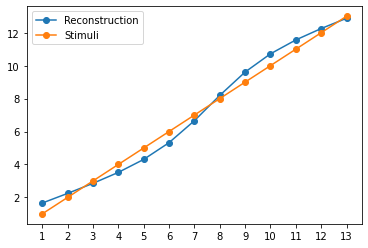

In [8]:
# sanity-check: plot reconstruction, for all stimuli.
recon = [r(x,cats,mu,sigma_c_2,sigma_s_2) for x in stims]
plt.plot(stims,recon, 'o-', label='Reconstruction')
plt.plot(stims,stims, 'o-', label='Stimuli')
plt.legend()
plt.xticks(stims)
plt.show()

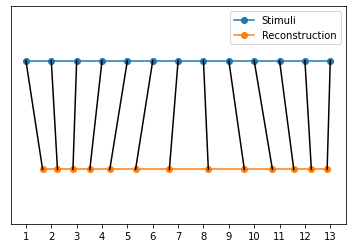

In [9]:
# plot again, in an easier-to-understand way.
recon = [r(x,cats,mu,sigma_c_2,sigma_s_2) for x in stims]
# plotting all reconstructions at y=3, and all original stimuli at y=1.
plt.plot(stims, [3]*len(stims), 'o-', label='Stimuli')
plt.plot(recon, [1]*len(stims), 'o-', label='Reconstruction')
# now connect original stims to reconstructions with black lines
for i in range(len(stims)):
    plt.plot([stims[i],recon[i]], [3,1], 'black')
plt.legend()
plt.xticks(stims)
plt.ylim(0,4)
frame = plt.gca()
frame.axes.get_yaxis().set_visible(False)
plt.show()

In [10]:
# now place reconstruction data in the same format as iverson and kuhl data, to compare.
recon_dist = {(i,i+1): abs(recon[i] - recon[i-1]) for i in range(1,12+1)}  # REPLACE - YOUR CODE GOES HERE.
print(recon)
recon_dist

[1.6582517996577688, 2.244350595546492, 2.8542806909436074, 3.519681690913163, 4.30638129351018, 5.322797738716654, 6.655659634938505, 8.191968886178566, 9.611031994372237, 10.71842345136212, 11.56124359031088, 12.254088162715188, 12.8761468749553]


{(1, 2): 0.5860987958887232,
 (2, 3): 0.6099300953971154,
 (3, 4): 0.6654009999695556,
 (4, 5): 0.7866996025970168,
 (5, 6): 1.016416445206474,
 (6, 7): 1.3328618962218517,
 (7, 8): 1.536309251240061,
 (8, 9): 1.4190631081936704,
 (9, 10): 1.107391456989884,
 (10, 11): 0.8428201389487597,
 (11, 12): 0.692844572404308,
 (12, 13): 0.6220587122401113}

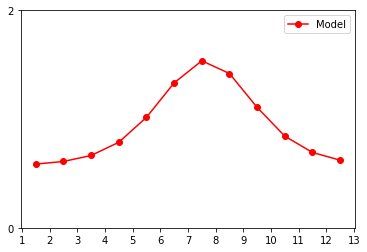

In [11]:
# plot model reconstruction data as you did iverson and kuhl empirical data.
xt = [i+1 for i in range(len(recon_dist)+1)]   # x tick mark posns, at stimulus numbers
x = [(i+j)/2 for (i,j) in recon_dist.keys()]  # actual x values to plot, *between* stimulus numbers
y = list(recon_dist.values())
plt.plot(x,y, 'ro-')  # red, circle marker, solid line
plt.xticks(xt,xt)
plt.yticks([0,2])
plt.ylim(0,2)
plt.legend(['Model'])
plt.show()

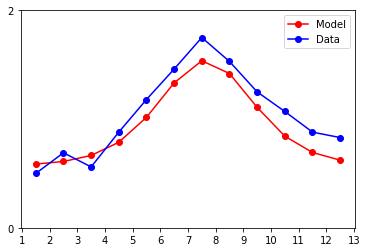

In [12]:
# plot model and data together
xt = [i+1 for i in range(len(recon_dist)+1)]   # x tick mark posns, at stimulus numbers
x = [(i+j)/2 for (i,j) in recon_dist.keys()]  # actual x values to plot, *between* stimulus numbers
y_model = list(recon_dist.values())
y_data= list(data.values())
plt.plot(x,y_model, 'ro-', label='Model')  # red, circle marker, solid line
plt.plot(x,y_data, 'bo-', label='Data')  # blue, circle marker, solid line
plt.xticks(xt,xt)
plt.yticks([0,2])
plt.ylim(0,2)
plt.legend()
plt.show()

That is a reasonable-looking fit but not quite what we see in Feldman et al.'s figure 3.  Note that they comment:

> Because multidimensional scaling gives relative, and
not absolute, distances between stimuli, we evaluated this comparison [between model and data]
on the basis of whether mel distances in the model were proportional
to distances found through multidimensional scaling. As shown in
Figure 3, the model yielded an extremely close fit to the empirical
data, yielding interstimulus distances that were proportional to those
found in multidimensional scaling ($r = .97$).

And of course what we're looking at in the figure above is absolute distance, not relative.  The fact that there is a qualitative alignment is promising, but the following questions remain open:
1. Does this alignment yield the reported Pearson correlation coefficient $r$ of .97?
2. What do model and data look like when aligned?

In [13]:
# check pearson correlation
# YOUR CODE GOES HERE - CAN USE scipy.stats.pearsonr
pearson_r, p = scipy.stats.pearsonr(y_data, y_model) # REPLACE - YOUR CODE GOES HERE.
print ("Pearson's r between model and data is:", pearson_r)

Pearson's r between model and data is: 0.9674085600229999


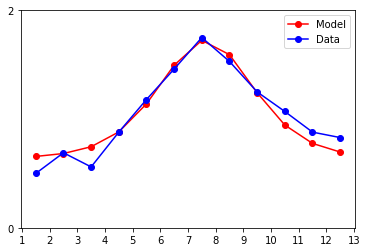

In [14]:
# plot model and data together, this time aligned.  use linear regression to align them.
xt = [i+1 for i in range(len(recon_dist)+1)]   # x tick mark posns, at stimulus numbers
x = [(i+j)/2 for (i,j) in recon_dist.keys()]  # actual x values to plot, *between* stimulus numbers
y_model = list(recon_dist.values())
y_data= list(data.values())

# scale y_model to fit y_data
# this follows https://realpython.com/linear-regression-in-python/
# params to fit are x,y - so here we are getting betas to convert y_model into y_data.
model = LinearRegression().fit(np.array(y_model).reshape((-1, 1)), np.array(y_data))
intercept = model.intercept_
slope = model.coef_[0]
scaled_y_model = [(slope*x)+intercept for x in y_model]

plt.plot(x,scaled_y_model, 'ro-', label='Model')  # red, circle marker, solid line
plt.plot(x,y_data, 'bo-', label='Data')  # blue, circle marker, solid line
plt.xticks(xt,xt)
plt.yticks([0,2])
plt.ylim(0,2)
plt.legend()
plt.show()

### Fitting the model to data

So far we have used parameter values reported by Feldman et al., and on that basis we have replicated their reported fit of the model to the Iverson and Kuhl data, both quantitatively via correlation, and qualitatively via visual comparison with Feldman et al.'s figure 3.  In this last section, we will only pre-specify certain parameter values, leaving others free to vary, and we will set those parameters by fitting the model to the data.  Specifically:

1. We will leave stimulus uncertainty $\sigma^2_S$ free to vary, and adjust it to fit the model to the data, to see whether our model-fitting procedure yields the same value for this parameter, and the same overall fit, as reported by Feldman et al.

2. A model may succeed in fitting empirical data because of a meaningful match between the structures of the model and the forces that produced the data in the real world.  Alternatively, a model may succeed in fitting the data for a much less interesting reason: if the model is highly flexible, it could in principle fit many different sorts of data, including the empirical data we have but also including other sorts of data that hypothetically could exist, but do not.  To explore this possibility, and hopefully rule it out, we will also attempt to fit the Feldman et al. model to hypothetical rather than real data.

### Objective function

We will fit the model to the data using  <span style="font-family:Courier New">minimize</span> from <span style="font-family:Courier New">scipy.optimize</span>, which we used earlier in the maxent OT homework.  This requires that we define an objective function which, when minimized, yields a solution to our problem.

We will have a solution to our problem when the model output (stimulus reconstruction) aligns well with the empirical data.  We will use mean squared error as a measure of alignment in our objective function.  After fitting, we can also follow up using Pearson's $r$ as we did above and as reported by Feldman et al. 

We will minimize this function by fitting $\sigma^2_S$ to the data &mdash; but there is a dependency here that we need to be careful about.  The probability of assigning each stimulus to each category is given by $p(c|S)$ above, and this quantity, which was fit to other data, depends on the sum $\sigma^2_c + \sigma^2_S$.  We don't want to disturb that other data-fit, so we will keep the sum $\sigma^2_c + \sigma^2_S$ fixed while we adjust $\sigma^2_S$ here.  We will do that by also adjusting $\sigma^2_c$ to compensate for any change to $\sigma^2_S$, keeping the sum of the two quantities constant.

In [15]:
def obj(ss, stims,cats,mu,summed_sigma_2,data):
    """
    objective fn for fitting feldman et al. model to data.
    accepts as input:
    ss, which corresponds to sigma_s UNSQUARED - we pass this in, rather than sigma_s squared,
    so sigma^2 cannot go negative during fitting.
    other_vars are:
    stims - stimuli 
    cats - categories
    mu - category means
    summed_sigma_2 - sum of cat and stimulus vars
    data - iverson and kuhl data, to fit.
    returns:
    mean squared error between model and data. 
    """
    
    # sigma_s_2 is ss squared, and sigma_c_2 is determined from that.
    # this preserves the dependency mentioned above.
    sigma_s_2 = ss*ss  # set sigma_s_2 to the passed-in value, squared.
    sigma_c_2 = summed_sigma_2 - sigma_s_2
    
    # YOUR CODE GOES HERE.
    recon = [r(x,cats,mu,sigma_c_2,sigma_s_2) for x in stims]
    recon_dist = {(i+1,i+2): abs(recon[i+1]-recon[i]) for i in range(len(recon)-1)}

    # find mean squared error, and return that value.
    x = list(data.values())
    y = list(recon_dist.values())

    # for unclear reasons, y sometimes appears as a list of floats (good), but when this fn is
    # called from within minimize, y appears as a list of 1-element numpy.ndarrays instead (bad).  
    # so here i correct for that possibility.  this is admittedly a total kludge.
    if not isinstance(y[0], float):
        y = [elt[0] for elt in y]

    mse = mean_squared_error(x,y)
    return(mse)

In [16]:
# sanity-check: see what our objective function returns for a wide variety of ss values.
for ss in [0.01, 2, 5, 25, 50, 100]:
    print(ss,obj(ss,stims,cats,mu,summed_sigma_2,data))

0.01 0.14601199511624138
2 0.030362062516353937
5 0.8085879502080294
25 1644.2876547819135
50 27433.37085875862
100 443520.72801905725


In [17]:
# ss is the *unsquared* sigma of stimulus.
# we start ss at a value known to yield not a very good fit, from our above sanity-check.
ss = 100
x0 = np.array([ss])  # arbitrary starting point
print("ss is", ss)
# now optimize.
print("objective before minimization:", obj(ss,stims,cats,mu,summed_sigma_2,data))
res = minimize(obj, x0, args=(stims,cats,mu,summed_sigma_2,data), 
               options={'disp': True, 'maxiter': 10000}, tol = 1.0E-6)
print("objective after minimization:", res.fun)
ss = res.x[0]
print("ss after minimization:", ss)

ss is 100
objective before minimization: 443520.72801905725
Optimization terminated successfully.
         Current function value: 0.023427
         Iterations: 23
         Function evaluations: 54
         Gradient evaluations: 27
objective after minimization: 0.023426881544675652
ss after minimization: 2.290917992847011


In [18]:
# sanity-check - make sure that the model fit is in fact good with these parameters.
# set your variables appropriately, based on optimization above.
sigma_s_2 = ss*ss
print("Fit value for sigma_s_2 =", sigma_s_2, "- Feldman et al.'s value = 4.987777776")
sigma_c_2 = summed_sigma_2 - sigma_s_2
recon = [r(x,cats,mu,sigma_c_2,sigma_s_2) for x in stims]
recon_dist = {(i+1,i+2): abs(recon[i+1]-recon[i]) for i in range(len(recon)-1)}  # REPLACE - YOUR CODE GOES HERE.
x = list(data.values())
y = list(recon_dist.values())

# first a quantitative sanity-check, via pearson correlation.
# YOUR CODE GOES HERE - CAN USE scipy.stats.pearsonr
pearson_r, p = scipy.stats.pearsonr(x,y)  # REPLACE - YOUR CODE GOES HERE.
print ("Pearson's r between model and data is:", pearson_r)

Fit value for sigma_s_2 = 5.248305249950178 - Feldman et al.'s value = 4.987777776
Pearson's r between model and data is: 0.967408560023


In [19]:
display(x)
display(y)

[0.5, 0.69, 0.56, 0.88, 1.18, 1.46, 1.75, 1.53, 1.25, 1.07, 0.88, 0.83]

[0.5644794214869782,
 0.5895555054546433,
 0.6479238315432392,
 0.7755582454188046,
 1.0172739282766825,
 1.3502483301993662,
 1.564322386699704,
 1.4409521052393597,
 1.113000853853558,
 0.8346101356177069,
 0.6768008689244418,
 0.6023176384746911]

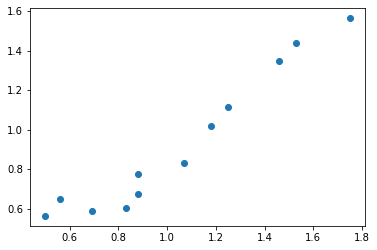

In [20]:
plt.scatter(x,y)
plt.show()

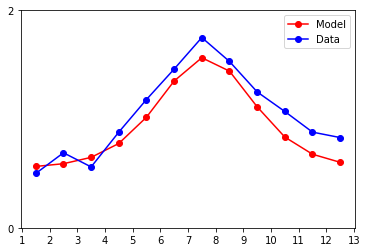

In [21]:
# now a visual sanity-check: plot model vs. data, as before.  but don't scale the data.
xt = [i+1 for i in range(len(recon_dist)+1)]   # x tick mark posns, at stimulus numbers
x = [(i+j)/2 for (i,j) in recon_dist.keys()]  # actual x values to plot, *between* stimulus numbers
y_model = list(recon_dist.values())
y_data= list(data.values())
plt.plot(x,y_model, 'ro-', label='Model')  # red, circle marker, solid line
plt.plot(x,y_data, 'bo-', label='Data')  # blue, circle marker, solid line
plt.xticks(xt,xt)
plt.yticks([0,2])
plt.ylim(0,2)
plt.legend()
plt.show()

### Hypothetical data

It's nice that we are able to fit the model to the empirical data.  But how do we know the model isn't overly flexible, such that it could also fit data very much unlike the data we see here?

To test this, we will attempt to fit the model again, but this time to **hypothetical data** - specifically we will take the real Iverson and Kuhl data and invert them, flipping them around the value y = 1, and see if we can fit that artificial data set that has been deliberately made to look quite unlike the real data.

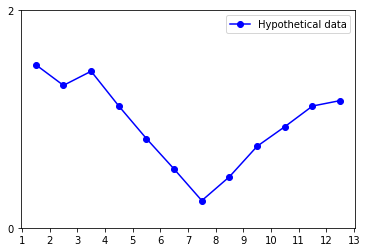

In [22]:
# create hypothetical data, and plot.
# invert the data.
hdata = {key: (2 - data_point) for key, data_point in data.items()}  # REPLACE - YOUR CODE GOES HERE.
xt = [i+1 for i in range(len(hdata)+1)]   # x tick mark posns, at stimulus numbers
x = [(i+j)/2 for (i,j) in hdata.keys()]  # actual x values to plot, *between* stimulus numbers
y = list(hdata.values())
plt.plot(x,y, 'bo-')  # blue, circle marker, solid line
plt.xticks(xt,xt)
plt.yticks([0,2])
plt.ylim(0,2)
plt.legend(['Hypothetical data'])
plt.show()

In [23]:
# now fit to the hypothetical data.
# ss is the *unsquared* sigma of stimulus.
ss = 100
x0 = np.array([ss])  # arbitrary starting point
print("ss is", ss)
# now optimize.
print("objective before minimization:", obj(ss,stims,cats,mu,summed_sigma_2,data))
res = minimize(obj, x0, args=(stims,cats,mu,summed_sigma_2,hdata), 
               options={'disp': True, 'maxiter': 10000}, tol = 1.0E-6)
print("objective after minimization:", res.fun)
ss = res.x[0]
print("ss after minimization:", ss)

ss is 100
objective before minimization: 443520.72801905725
Optimization terminated successfully.
         Current function value: 0.146017
         Iterations: 20
         Function evaluations: 44
         Gradient evaluations: 22
objective after minimization: 0.14601666666671198
ss after minimization: -9.850028375633056e-07


In [24]:
# now examine the results of this fit to hypothetical data.
# set your variables appropriately, based on optimization above.
sigma_s_2 = ss*ss
print("Fit value for sigma_s_2 =", sigma_s_2)
sigma_c_2 = summed_sigma_2 - sigma_s_2

# now reconstruct stimuli based on these new parameters.
recon = [r(x,cats,mu,sigma_c_2,sigma_s_2) for x in stims]
recon_dist = {(i+1,i+2): abs(recon[i+1]-recon[i]) for i in range(len(recon)-1)}  # REPLACE - YOUR CODE GOES HERE.
x = list(hdata.values())
y = list(recon_dist.values())

# first a quantitative sanity-check, via pearson correlation.
# YOUR CODE GOES HERE - CAN USE scipy.stats.pearsonr
pearson_r, p = scipy.stats.pearsonr(x,y)  # REPLACE - YOUR CODE GOES HERE.
print ("Pearson's r between model and data is:", pearson_r)

Fit value for sigma_s_2 = 9.702305900077638e-13
Pearson's r between model and data is: -0.967522787632184


In [25]:
display(x)
display(y)

[1.5,
 1.31,
 1.44,
 1.12,
 0.8200000000000001,
 0.54,
 0.25,
 0.47,
 0.75,
 0.9299999999999999,
 1.12,
 1.17]

[0.9999999999999194,
 0.9999999999999241,
 0.9999999999999352,
 0.9999999999999583,
 1.0000000000000036,
 1.000000000000064,
 1.0000000000001048,
 1.0000000000000817,
 1.0000000000000213,
 0.999999999999968,
 0.9999999999999414,
 0.9999999999999272]

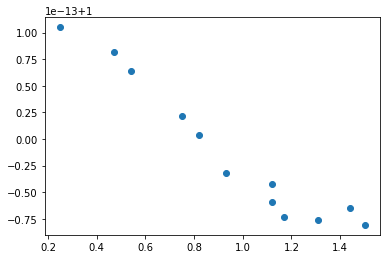

In [26]:
plt.scatter(x,y)
plt.show()

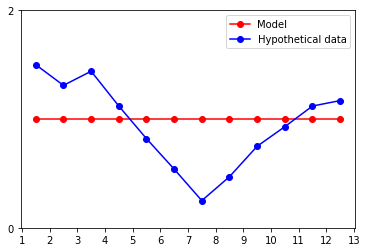

In [27]:
# now a visual sanity-check: plot model vs. data, as before.  but don't scale the data.
xt = [i+1 for i in range(len(recon_dist)+1)]   # x tick mark posns, at stimulus numbers
x = [(i+j)/2 for (i,j) in recon_dist.keys()]  # actual x values to plot, *between* stimulus numbers
y_model = list(recon_dist.values())
y_data= list(hdata.values())
plt.plot(x,y_model, 'ro-', label='Model')  # red, circle marker, solid line
plt.plot(x,y_data, 'bo-', label='Hypothetical data')  # blue, circle marker, solid line
plt.xticks(xt,xt)
plt.yticks([0,2])
plt.ylim(0,2)
plt.legend()
plt.show()

# Observations and conclusions

- Write your general observations about the results here, and conclusions you can draw from them.  A short paragraph would be fine, but please separately specify observations and conclusions.

##### Observations:
- 

##### Conclusions:
- 